# SIS Lens

This part interpolates the amplification factor for the SIS lens using the data obtained from the MATHEMATICA file.

~ Saif 8/21

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, find_peaks_cwt
from gw_lens_dir.overlap_lensing_sis import overlap_sis 
from scipy.interpolate import interp1d
%matplotlib inline

In [18]:
def cleanData(filePath = '/Users/saifali/Desktop/gwlensing/data/', 
              fileName = None):
    
    with open(filePath + fileName) as f:
        read = f.readlines()
    results_temp = [float(s) for s in read[0][1:-1].split(',')]
    results = [i for n, i in enumerate(results_temp) if i not in results_temp[:n]]
    
    return np.array(results)

freq = cleanData(fileName = 'freq_interpolate_y_0.5.txt')
Fsis_abs = cleanData(fileName = 'abs_ampfact_interpolate_y_0.5.txt')

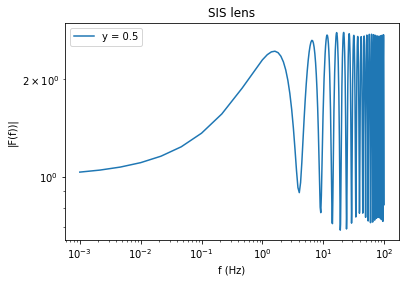

In [19]:
plt.loglog(freq, Fsis_abs, label = f"y = 0.5")
plt.title("SIS lens")
plt.xlabel('f (Hz)')
plt.ylabel('|F(f))|')
plt.legend()

In [24]:
def F_interp(freq, Fsis, freq_cut_val = 2, seed = None, random_size = 20):
    
    np.random.seed(seed)
    #[freq_cut_val] = Hz
    
    freq_cut = freq[freq < freq_cut_val]
    Fsis_cut = Fsis[:len(freq_cut)]
    
    
    '''
    freq_cut = freq
    Fsis_cut = Fsis
    '''
    
    
    if Fsis[0] > 0:
        plt.loglog(freq_cut, Fsis_cut, marker = 'x')
    else:
        plt.plot(freq_cut, Fsis_cut, marker = 'x')
    
    freq_interp = np.random.uniform(low = freq_cut[0], high = freq_cut[-1], size = random_size)
    Fsis_interp = np.zeros_like(freq_interp)

    for i in range(random_size):
        Fsis_interp_temp = interp1d(freq_cut, Fsis_cut)
        Fsis_interp[i] = Fsis_interp_temp(freq_interp[i])
    
    if Fsis[0] > 0:
        plt.loglog(freq_interp, Fsis_interp, '.', label = 'interpolated')
    else:
        plt.semilogx(freq_interp, Fsis_interp, '.', label = 'interpolated')
    plt.legend()
    
    return freq_interp, Fsis_interp

Text(0, 0.5, '|F(f)|')

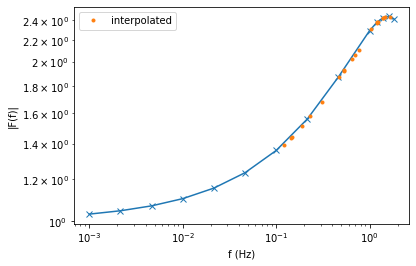

In [25]:
# absolute value of amplification factor
F_interp(freq = freq, Fsis = Fsis_abs)
plt.xlabel('f (Hz)')
plt.ylabel('|F(f)|')

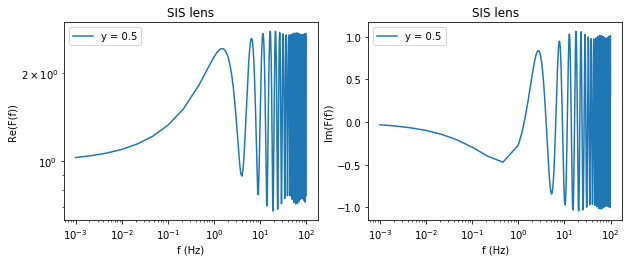

In [26]:
freq = cleanData(fileName = 'freq_interpolate_y_0.5.txt')
Fsis_real = cleanData(fileName = 're_ampfact_interpolate_y_0.5.txt')
Fsis_im = cleanData(fileName = 'im_ampfact_interpolate_y_0.5.txt')

plt.figure(figsize = (10, 8))
plt.subplot(2, 2, 1)
plt.loglog(freq, Fsis_real, label = "y = 0.5")
plt.title("SIS lens")
plt.xlabel('f (Hz)')
plt.ylabel('Re(F(f))')
plt.legend()

plt.subplot(2, 2, 2)
plt.semilogx(freq, Fsis_im, label = "y = 0.5")
plt.title("SIS lens")
plt.xlabel('f (Hz)')
plt.ylabel('Im(F(f))')
plt.legend()

Text(0, 0.5, 'Im(F(f))')

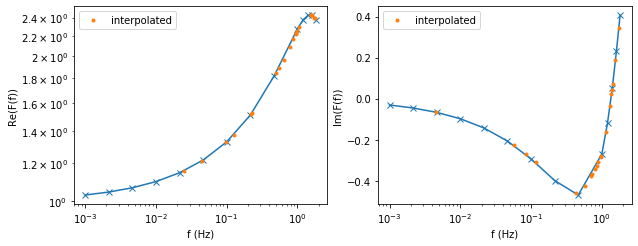

In [27]:
plt.figure(figsize = (10, 8))

plt.subplot(2, 2, 1)
F_interp(freq, Fsis_real)
plt.xlabel('f (Hz)')
plt.ylabel('Re(F(f))')
plt.subplot(2, 2, 2)
F_interp(freq, Fsis_im)
plt.xlabel('f (Hz)')
plt.ylabel('Im(F(f))')

## Trying the infinite sum from this [paper](https://arxiv.org/pdf/2112.07012.pdf)

In [28]:
def my_lin(lb, ub, steps, spacing = 3):
    span = (ub-lb)
    dx = 1.0 / (steps-1)
    return np.array([lb + (i * dx) ** spacing * span for i in range(steps)])
#my_lin(1e2 * solar_mass, 1e6 * solar_mass, 20)/solar_mass

In [29]:
M_lz_source_range = my_lin(1e2 * solar_mass, 1e4 * solar_mass, 15)
print(M_lz_source_range / solar_mass)
print(M_lz_source_range)

[  100.           103.60787172   128.86297376   197.41253644
   330.90379009   550.98396501   879.30029155  1337.5
  1947.2303207   2730.13848397  3707.87172012  4902.07725948
  6334.40233236  8026.4941691  10000.        ]
[0.00049262 0.0005104  0.00063481 0.0009725  0.00163011 0.00271428
 0.00433164 0.00658885 0.00959253 0.01344932 0.01826587 0.02414881
 0.03120479 0.03954044 0.04926241]


In [5]:
from mpmath import *

solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
giga_parsec = 1.02927125 * 10**17 #[giga_parsec] = sec
year = 31557600 #[year] = sec
mp.pretty = True 

freq = my_lin(0.001, 250, 500)

def Fsis(f):
    
    ml = 1e5 * solar_mass
    w = 8 * pi * ml * f
    y = 0.5
    
    pre_factor = exp(1j * (w / 2) * (y**2 + 2 * (y + 0.5))) 
    func = lambda n: (gamma(1 + n / 2) / fac(n)) * (2 * w * exp(1j * 3 * (pi / 2))) ** (n / 2) * hyp1f1(1 + n / 2, 1, -1j * (w / 2) * y ** 2)
    
    series_sum = nsum(func, [0, inf])
    
    return pre_factor * series_sum

Fsis_series = np.zeros_like(freq)

for i in range(len(freq)):
    Fsis_series[i] = np.abs(Fsis(freq[i]))

In [21]:
peaks, _ = find_peaks(Fsis_series) 
freq_at_peaks = freq[peaks][0]
print(freq_at_peaks)

0.15985329528114506


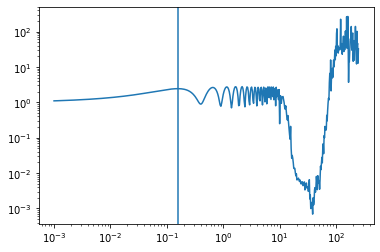

In [22]:
plt.loglog(freq, Fsis_series)
plt.axvline(x = freq_at_peaks)

## Overlap analysis for the SIS lens

In [21]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
giga_parsec = 1.02927125 * 10**17 #[giga_parsec] = sec
year = 31557600 #[year] = sec

initial_params_source = {
    'theta_s_source' : 0.0, 
    'phi_s_source' : 0.0, 
    'theta_l_source' : 0.0, 
    'phi_l_source' : 0.0, 
    'mcz_source' : 18.79 * solar_mass, 
    'dist_source': 1.58 * giga_parsec, 
    'eta_source' : 0.25, 
    't0' : 0.0, 
    'phi_0' : 0.0,
    'M_lz_source':1e4 * solar_mass,
    'y_source': 0.5
}

initial_params_template = {
    'theta_s_temp' : 0.0, 
    'phi_s_temp' : 0.0, 
    'theta_l_temp' : 0.0, 
    'phi_l_temp' : 0.0, 
    'mcz_temp' : 18.79 * solar_mass, 
    'dist_temp': 1.58 * giga_parsec, 
    'eta_temp' : 0.25, 
    #'tc' : 0.0, 
    #'phi_c' : 0.0,
}

In [22]:
overlap_sis_init = overlap_sis(params_source = initial_params_source,
                              params_temp = initial_params_template) 

In [23]:
overlap_sis_init.limit(initial_params_source, initial_params_template)

(20, 101.84620327015129, 101.84620327015129, 101.84620327015129)

In [ ]:
overlap_sis_init.get_f_transition()

In [ ]:
overlap_sis_init.overlap(x = [0, 0])

In [30]:
f_trans = np.zeros_like(M_lz_source_range)
for i in range(len(M_lz_source_range)):
    params_source = initial_params_source
    params_source['M_lz_source'] = M_lz_source_range[i]
    overlap_sis_initialized = overlap_sis(params_source = params_source,
                                          params_temp = initial_params_template)
    f_trans[i] = overlap_sis_initialized.get_f_transition()

In [31]:
f_trans

array([157.03022948, 152.07703594, 121.0387089 ,  79.07112892,
        47.60397708,  28.18485643,  17.86536374,  11.76946465,
         8.1262606 ,   5.78510611,   4.2684571 ,   3.19412341,
         2.49796474,   1.93736839,   1.5801997 ])